In [3]:
# Импортируем библиотеки

# База
import numpy as np # линеная алгебра
import pandas as pd # работа с данными
import datetime as dt

# Визуализация
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

# для корректного преобразования разности дат в число
from operator import attrgetter

# SQL

In [1]:
import sqlite3
con = sqlite3.connect('db')
cur = con.cursor()

In [2]:
def select(sql):
  return pd.read_sql(sql,con)

In [7]:
data = pd.read_csv("/content/cohort_data.csv")

In [8]:
data['order_date'] = pd.to_datetime(data['order_date'],format='%Y-%m-%d')

In [9]:
data.to_sql('trans',con,index=False,if_exists='replace')

10926

In [10]:
sql = ''' select * from trans t'''

In [11]:
select(sql)

,client_id,order_date,order_price,city_id
0,43017,2022-01-01 00:00:00,10000,1
1,43022,2022-01-01 00:00:00,7700,3
2,43104,2022-01-01 00:00:00,3200,1
3,43116,2022-01-01 00:00:00,9700,1
4,43153,2022-01-01 00:00:00,6750,2
...,...,...,...,...
10921,52725,2022-10-31 00:00:00,6500,1
10922,52769,2022-10-31 00:00:00,6550,3
10923,52813,2022-10-31 00:00:00,4650,2
10924,52879,2022-10-31 00:00:00,1800,2


In [12]:
sql = ''' select t.client_id, date(min(order_date),'start of month') as order_month from trans t
group by t.client_id'''

In [13]:
select(sql)

,client_id,order_month
0,43000,2022-01-01
1,43001,2022-01-01
2,43002,2022-01-01
3,43003,2022-01-01
4,43004,2022-01-01
...,...,...
8920,52914,2022-10-01
8921,52915,2022-10-01
8922,52916,2022-10-01
8923,52917,2022-10-01


In [14]:
min = '''select date(min(t.order_date),'start of month') from trans t'''

In [15]:
select(min)

,"date(min(t.order_date),'start of month')"
0,2022-01-01


In [16]:
max = '''select date(max(order_date),'start of month') from trans t'''
select(max)

,"date(max(order_date),'start of month')"
0,2022-10-01


In [17]:
sql = f'''WITH RECURSIVE dates(date) AS (
  VALUES(({min}))
  UNION ALL
  SELECT date(date, '+1 month')
  FROM dates
  WHERE date < ({max})
)
SELECT date FROM dates;'''

In [18]:
select(sql)

,date
0,2022-01-01
1,2022-02-01
2,2022-03-01
3,2022-04-01
4,2022-05-01
5,2022-06-01
6,2022-07-01
7,2022-08-01
8,2022-09-01
9,2022-10-01


In [19]:
sql = f'''with clients as  (select t.client_id, date(min(order_date),'start of month') as order_month from trans t
group by t.client_id),

dates as (

WITH RECURSIVE dates(date) AS (
  VALUES(({min}))
  UNION ALL
  SELECT date(date, '+1 month')
  FROM dates
  WHERE date < ({max})
)
SELECT date FROM dates

),

template as (

select t.client_id, t.order_month, d.date as month from clients t
join dates d on d.date >= t.order_month),

order_month as (

select t.client_id,
date(t.order_date,'start of month') as month,

sum(t.order_price) as order_price_sum,
count(1) as order_cnt


 from trans t

 group by
t.client_id,
date(t.order_date,'start of month')

),

report as (
select t.*, tm.order_price_sum, tm.order_cnt,
case when tm.order_price_sum > 0 then 1 else 0 end as active,

round((julianday(t.month) - julianday(t.order_month)) / 30) as lifetime

 from template t
left join order_month tm on t.client_id = tm.client_id and t.month = tm.month)


select t.order_month, t.lifetime, avg(t.active) as retention from report t
where t.order_month >= '2022-01-01'
group by t.order_month, t.lifetime

'''

In [20]:
t = select(sql)

In [21]:
to_heatmap = t.pivot_table(index='order_month',columns='lifetime',values='retention',aggfunc='max')

<Axes: xlabel='lifetime', ylabel='order_month'>

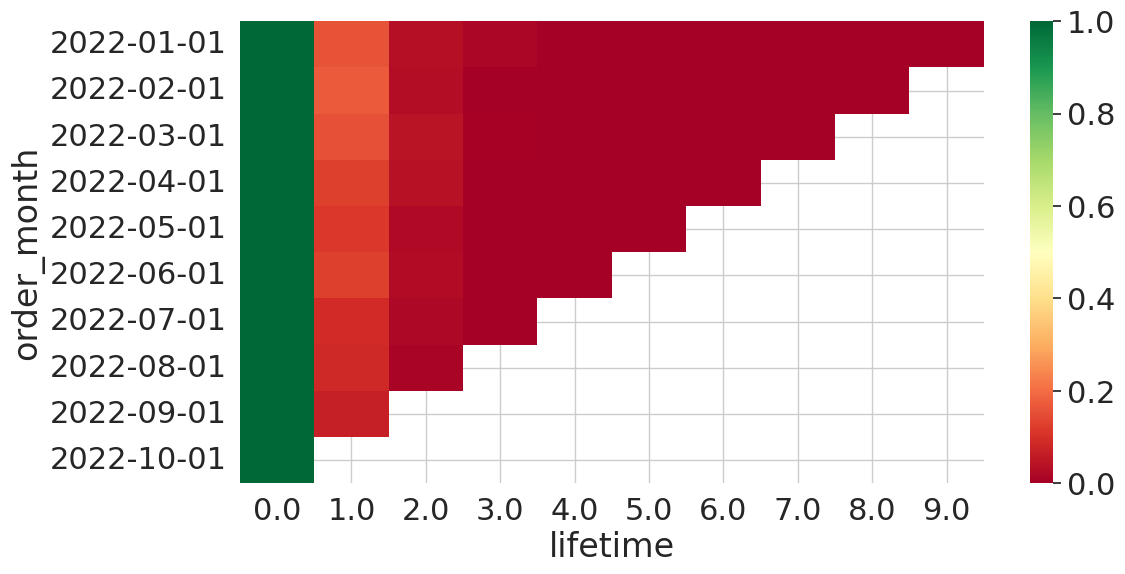

In [22]:
sns.set(font_scale=2,style="whitegrid",rc={'figure.figsize':(12,6)} )
sns.heatmap(to_heatmap, cmap='RdYlGn')



---



# Report

* Overall: Retention rate (RR) is declining during the first 10 months of 2022
* However, in May, the return rate of customers increased slightly after a month
* Already in the second month (index 1) there is a sharp decline, on average about 87% of customers do not place orders for the second month.
* How good RR is is determined in comparison with market leaders solving the same or at least a similar task. The indicator is also related to the specifics of the business

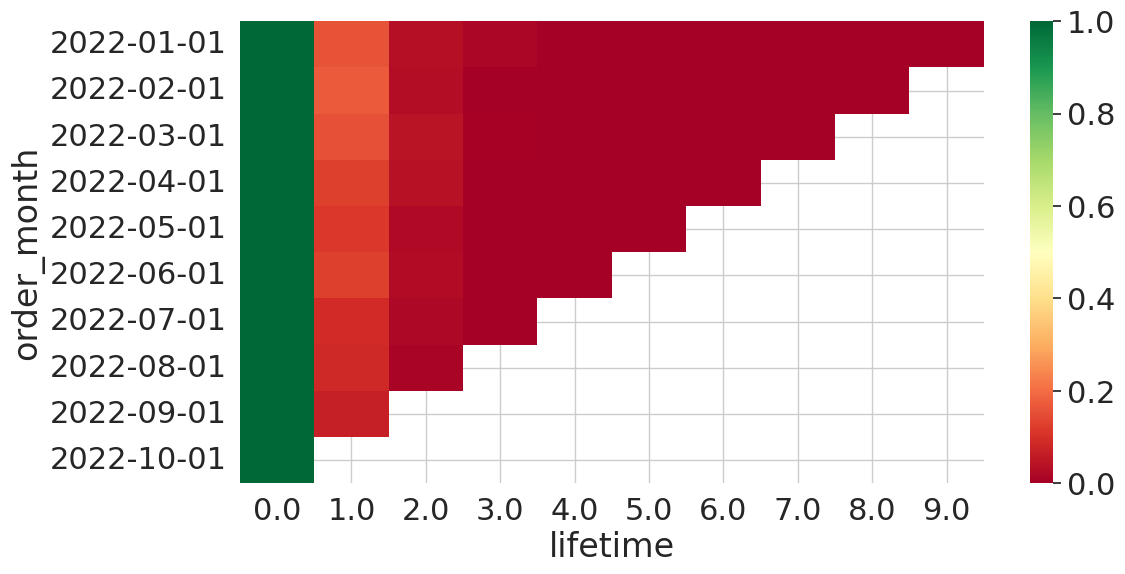

Достаточно анализировать первые 3 месяца